# Lab: Aprendizaje por refuerzo (I)
# 4 - Q-Learning

## Configuración y dependencias

In [1]:
# Declaración de constantes
SLIPPERY = False
T_MAX = 15
NUM_EPISODES = 5
GAMMA = 0.95
REWARD_THRESHOLD = 0.9
LEARNING_RATE = 0.5
EPSILON = 0.8

In [ ]:
!pip install gymnasium seaborn numpy

In [3]:
import gymnasium as gym
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from gymnasium import Wrapper

In [4]:
env = gym.make("FrozenLake-v1", desc=None, map_name="4x4", render_mode="human", is_slippery=SLIPPERY)

def test_episode(agent, env):
    env.reset()
    is_done = False
    t = 0

    while not is_done:
        action = agent.select_action()
        state, reward, is_done, truncated, info = env.step(action)
        t += 1
    return state, reward, is_done, truncated, info

def draw_rewards(rewards):
    data = pd.DataFrame({'Episode': range(1, len(rewards) + 1), 'Reward': rewards})
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Episode', y='Reward', data=data)

    plt.title('Rewards Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid(True)
    plt.tight_layout()

    plt.show()
    
def print_policy(policy):
    visual_help = {0:'<', 1:'v', 2:'>', 3:'^'}
    policy_arrows = [visual_help[x] for x in policy]
    print(np.array(policy_arrows).reshape([-1, 4]))

## Q-Learning

En esta parte de la sesión vamos a ver una posible implementación del algoritmo Q-Learning (epsilon-based). Esta implementación sigue el algoritmo que habéis visto en clase de teoría, por lo que os podéis guiar por el pseudocódigo si es necesario para entender el código:

In [27]:
class QLearningAgent:
    def __init__(self, env, gamma, learning_rate, epsilon, t_max, epsilon_decay, learning_rate_decay):
        self.env = env
        self.Q = np.zeros((env.observation_space.n, env.action_space.n))
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = 0.05
        self.t_max = t_max

    def select_action(self, state, training=True):
        if training and random.random() <= self.epsilon:
            return np.random.choice(self.env.action_space.n)
        else:
            return np.argmax(self.Q[state,])
        if self.epsilon > self.epsilon_min:
           self.epsilon *= self.epsilon_decay
        
    def update_Q(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.Q[next_state,])
        td_target = reward + self.gamma * self.Q[next_state, best_next_action]
        td_error = td_target - self.Q[state, action]
        self.Q[state, action] += self.learning_rate * td_error
        #self.learning_rate *= self.learning_rate_decay
        
    def learn_from_episode(self):
        state, _ = env.reset()
        total_reward = 0
        for i in range(self.t_max):
            action = self.select_action(state)
            new_state, new_reward, is_done, truncated, _ = self.env.step(action)
            total_reward += new_reward
            self.update_Q(state, action, new_reward, new_state)
            if is_done:
                break
            state = new_state
        return total_reward

    def policy(self):
        policy = np.zeros(env.observation_space.n) 
        for s in range(env.observation_space.n):
            policy[s] = np.argmax(np.array(self.Q[s]))        
        return policy

Observad que el algoritmo recibe varios parámetros que pueden influir en el rendimiento del algoritmo: el factor de descuento, la tasa de aprendizaje, el coeficiente de exploración y el número máximo de pasos por episodio. También deberíais tener en cuenta el número de episodios. En la siguiente celda usamos las constantes definidas al inicio del notebook, pero podéis cambiar los valores para probar diferentes opciones para intentar acelerar el entrenamiento.

In [ ]:
agent = QLearningAgent(env, gamma=GAMMA, learning_rate=LEARNING_RATE, epsilon=EPSILON, t_max=T_MAX)
rewards = []
for i in range(NUM_EPISODES):
    reward = agent.learn_from_episode()
    print("New reward: " + str(reward))
    rewards.append(reward)
draw_rewards(rewards)

**Jugad un rato con los parámetros para intentar conseguir que el agente consiga utilidades positivas en alguna iteración.**

Estamos viendo un problema recurrente con este entorno: las *sparse rewards*. Hay una manera de solucionarlo, que es intentando guiar mejor a través de la señal de recompensa. Con Gymnasium es sencillo hacerlo gracias a los Wrapper.

**Modificad el siguiente Wrapper para guiar mejor el entrenamiento del agente:**

In [28]:
class CustomFrozenLakeWrapper(Wrapper):
    def __init__(self, env):
        super().__init__(env)
    
    def step(self, action):
        state, reward, is_done, truncated, info = self.env.step(action)
        # Bonificar, penalizar
        if is_done and reward == 0:
            reward = -50
        elif is_done and reward == 1:
            reward = 100
        else:
            reward = -0.05
        return state, reward, is_done, truncated, info

Una vez tenéis una nueva señal de recompensa, la podéis probar con el siguiente código:

New reward: -50.35
New reward: -50.15
New reward: -50.15
New reward: -50.9
New reward: -50.2
New reward: -50.8
New reward: -50.55
New reward: -50.1
New reward: -50.15
New reward: -50.35
New reward: -50.65
New reward: -50.2
New reward: -50.85
New reward: 99.3
New reward: 99.15
New reward: -50.1
New reward: 99.35
New reward: -50.15
New reward: -50.3
New reward: -50.2
New reward: -50.05
New reward: -50.15
New reward: 99.55
New reward: 99.7
New reward: 99.55
New reward: 99.45
New reward: -50.05
New reward: 99.55
New reward: 99.75
New reward: -50.25
New reward: 99.65
New reward: -50.65
New reward: -50.05
New reward: 99.55
New reward: 99.55
New reward: 99.75
New reward: 99.75
New reward: -50.05
New reward: -50.7
New reward: -50.25
New reward: 99.65
New reward: 99.7
New reward: -50.05
New reward: 99.4
New reward: 99.05
New reward: -50.1
New reward: -50.1
New reward: 99.75
New reward: 99.6
New reward: -50.1


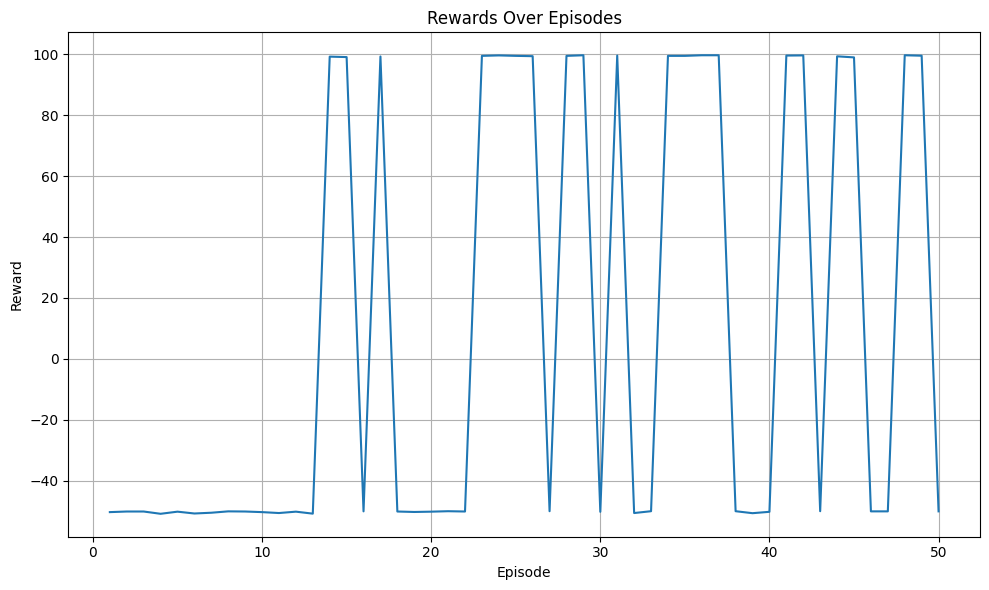

In [29]:
fixed_env = CustomFrozenLakeWrapper(env)
agent = QLearningAgent(fixed_env, gamma=GAMMA, learning_rate=LEARNING_RATE, epsilon=0.5, t_max=100, epsilon_decay=0.85, learning_rate_decay=0.9)
rewards = []
for i in range(50):
    reward = agent.learn_from_episode()
    print("New reward: " + str(reward))
    rewards.append(reward)
draw_rewards(rewards)

In [ ]:
policy = agent.policy()
print_policy(policy)

Como siempre, una vez el agente está entrenado, podemos probar su rendimiento en el entorno. Tenemos que asegurarnos de que el coeficiente de exploración no se tiene en cuenta en este caso:

Episode:  0
Episode:  1
Episode:  2
Episode:  3
Episode:  4


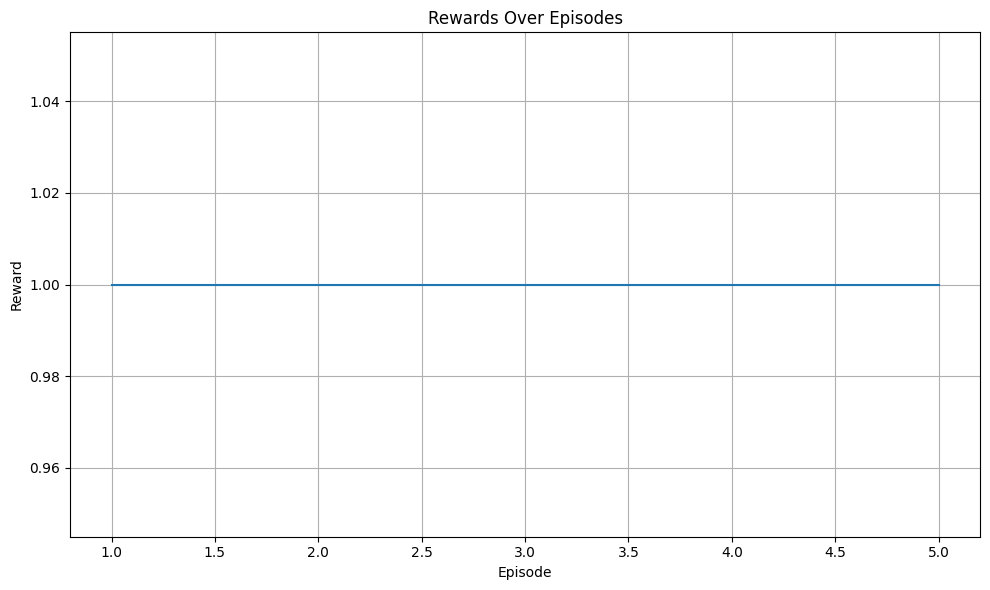

In [9]:
is_done = False
rewards = []
for n_ep in range(NUM_EPISODES):
    state, _ = env.reset()
    print('Episode: ', n_ep)
    total_reward = 0
    for i in range(T_MAX):
        action = agent.select_action(state, training=False)
        state, reward, is_done, truncated, _ = env.step(action)
        total_reward = total_reward + reward
        env.render()
        if is_done:
            break
    rewards.append(total_reward)
draw_rewards(rewards)

## Ejercicios propuestos

1. Añadir dos parámetros nuevos al QLearningAgent: un `epsilon_decay` y un `learning_rate_decay`, que vayan reduciendo ambos valores tras cada episodio para hacer que la política se vaya volviendo estable con el tiempo. También es recomendable añadir un `epsilon_min` para evitar un estancamiento hacia el final del entrenamiento si el resultado está lejos del óptimo. Generalmente, se suele reducir con la fórmula `epsilon = epsilon * epsilon_decay` y la correspondiente para la tasa de aprendizaje. Comprobad empíricamente el efecto de aplicar estos parámetros nuevos.
2. Cambiad `SLIPPERY` a True en todos los notebooks y observad la diferencia en el entrenamiento de los agentes. ¿Seríais capaces de encontrar una configuración para resolver FrozenLake-v1 con Q-Learning y `SLIPPERY=True`?
2. Aplicar estos mismos algoritmos en alguno de los otros entornos discretos de Gymnasium, como [Taxi](https://gymnasium.farama.org/environments/toy_text/taxi/) o [Cliff Walking](https://gymnasium.farama.org/environments/toy_text/cliff_walking/#).